In [3]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import GRU 
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.linear_model import ElasticNet,ElasticNetCV
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit


### Feature Engineering

A comparison is done in this script between using a dataframe with just the 'value' as the input feature and an enhanced dataframe. 

The enhanced dataframe incorporates the following features:
1. Month
2. Day of the Month
3. Day of the Week
4. Year 
5. The preceeding 20 lagging values 
6. The rolling 10 days mean
7. The rolling 10 days standard deviation

In [4]:
timeseries_df = pd.read_csv("dataset.csv")
timeseries_df.rename(columns={"ds": 'date', "total": 'value'}, inplace=True)

In [5]:
#cast date variable from string to date
timeseries_df['date'] = pd.to_datetime(timeseries_df['date'], format='%d/%m/%Y')
basic_df = timeseries_df.copy()
timeseries_df

,date,value
0,2020-01-01,21525
1,2020-01-02,48665
2,2020-01-03,49014
3,2020-01-04,38294
4,2020-01-05,39921
...,...,...
596,2021-08-19,119239
597,2021-08-20,100796
598,2021-08-21,76452
599,2021-08-22,80793


In [6]:
#extract seasonal features
timeseries_df['Month'] = timeseries_df['date'].dt.month
timeseries_df['DayOfMonth'] = timeseries_df['date'].dt.day
timeseries_df['DayOfWeek'] = timeseries_df['date'].dt.dayofweek 
timeseries_df['Year'] = timeseries_df['date'].dt.year 
timeseries_df

,date,value,Month,DayOfMonth,DayOfWeek,Year
0,2020-01-01,21525,1,1,2,2020
1,2020-01-02,48665,1,2,3,2020
2,2020-01-03,49014,1,3,4,2020
3,2020-01-04,38294,1,4,5,2020
4,2020-01-05,39921,1,5,6,2020
...,...,...,...,...,...,...
596,2021-08-19,119239,8,19,3,2021
597,2021-08-20,100796,8,20,4,2021
598,2021-08-21,76452,8,21,5,2021
599,2021-08-22,80793,8,22,6,2021


In [7]:
#used the lagged values as input features
lags = range(1,20,1)
for lag in lags:
    col = f'value_Lag{lag}'
    timeseries_df[col] = timeseries_df['value'].shift(lag)

In [8]:
#create the output value as 'pred'
timeseries_df['pred'] = timeseries_df['value'].shift(-1)
basic_df['pred'] = basic_df['value'].shift(-1)

#add the rolling mean and std as input feautres
timeseries_df['rolling_mean'] = timeseries_df['value'].rolling(10).mean()
timeseries_df['rolling_std'] = timeseries_df['value'].rolling(10).std()
timeseries_df = timeseries_df.dropna()
#del (timeseries_df['date'])

basic_df = basic_df.dropna()
basic_df = basic_df[19:]
#del (basic_df['date'])
timeseries_df

,date,value,Month,DayOfMonth,DayOfWeek,Year,value_Lag1,value_Lag2,value_Lag3,value_Lag4,...,value_Lag13,value_Lag14,value_Lag15,value_Lag16,value_Lag17,value_Lag18,value_Lag19,pred,rolling_mean,rolling_std
19,2020-01-20,92201,1,20,0,2020,64935.0,63751.0,75218.0,84148.0,...,59871.0,65741.0,39921.0,38294.0,49014.0,48665.0,21525.0,88624.0,75542.0,14465.296725
20,2020-01-21,88624,1,21,1,2020,92201.0,64935.0,63751.0,75218.0,...,60634.0,59871.0,65741.0,39921.0,38294.0,49014.0,48665.0,86336.0,79452.8,11662.121808
21,2020-01-22,86336,1,22,2,2020,88624.0,92201.0,64935.0,63751.0,...,71075.0,60634.0,59871.0,65741.0,39921.0,38294.0,49014.0,83137.0,81759.5,10308.034496
22,2020-01-23,83137,1,23,3,2020,86336.0,88624.0,92201.0,64935.0,...,62878.0,71075.0,60634.0,59871.0,65741.0,39921.0,38294.0,68059.0,81557.4,10253.668376
23,2020-01-24,68059,1,24,4,2020,83137.0,86336.0,88624.0,92201.0,...,49516.0,62878.0,71075.0,60634.0,59871.0,65741.0,39921.0,53077.0,79801.1,10959.923808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2021-08-18,130052,8,18,2,2021,140734.0,153603.0,82014.0,78020.0,...,125480.0,127942.0,134640.0,150090.0,84423.0,82577.0,114696.0,119239.0,126919.3,29385.974293
596,2021-08-19,119239,8,19,3,2021,130052.0,140734.0,153603.0,82014.0,...,112746.0,125480.0,127942.0,134640.0,150090.0,84423.0,82577.0,100796.0,121746.0,24994.523107
597,2021-08-20,100796,8,20,4,2021,119239.0,130052.0,140734.0,153603.0,...,96009.0,112746.0,125480.0,127942.0,134640.0,150090.0,84423.0,76452.0,117774.6,24836.421044
598,2021-08-21,76452,8,21,5,2021,100796.0,119239.0,130052.0,140734.0,...,98994.0,96009.0,112746.0,125480.0,127942.0,134640.0,150090.0,80793.0,112260.9,27415.204700


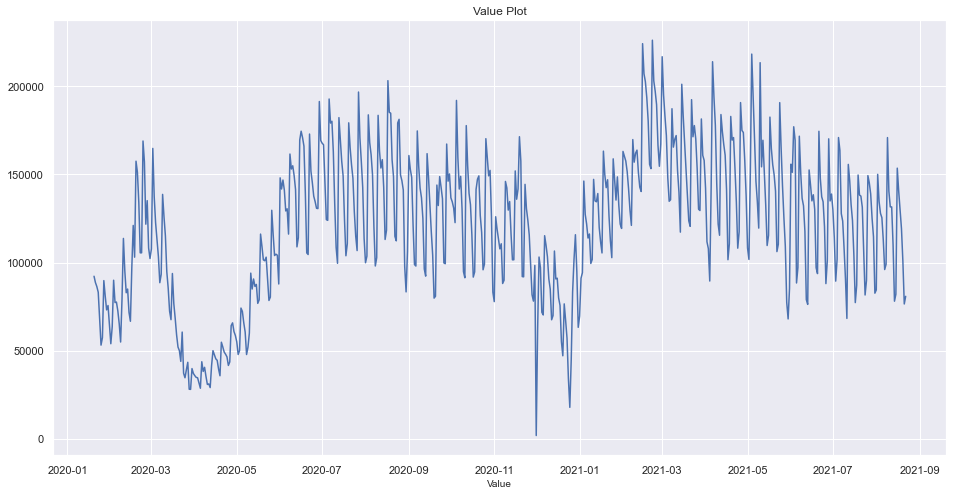

In [9]:
# Plot the value 
sns.set_theme()

plt.figure(figsize = (16,8))
plt.plot(timeseries_df['date'].values, timeseries_df['value'])
plt.title("Value Plot")
plt.xlabel("Value", fontsize= 10)
plt.show()

### Model Training


In [10]:
def moving_window_pred(data,window,model, params, grid):
    # Split data into equal partitions of size len_train
    num_train = 1
    #len_train = window #Length of each train-test set

    # Lists to store the results from each model
    pred = []
    act = []
    #result = pd.DataFrame(columns=['actual', 'predicted'])

    #i = 0
    i = int(window/num_train)+1
    loop_counter = 1
    
    while True:
        # partition data into moving windows
        df = data.iloc[(i * num_train) - window : (i * num_train) ]
        #print(df)
        
        if len(df) < window:
            break
                      
        y = np.array(df['pred'])
        features = [x for x in df.columns if x not in ['pred','date']]
        X = np.array(df[features])
        
        scaler = StandardScaler()      
        X_scaled = scaler.fit_transform(X)
        
        X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, train_size= window-1,shuffle=False)
        
        tscv = TimeSeriesSplit(n_splits=3)
        if grid ==1:
            
            grid_model = GridSearchCV(model, params, n_jobs=-1, verbose=0, cv=tscv)
            grid_model.fit(X_train_scaled, y_train_scaled)
            prediction = grid_model.predict(X_test_scaled)
        elif grid ==0:
            model.fit(X_train_scaled, y_train_scaled)
            prediction = model.predict(X_test_scaled)
            
        #print('act',y_test_scaled, 'pred', predictions_grid_model )
        pred.append(prediction)
        act.append(y_test_scaled)
                
        i += 1
    r2 = r2_score(act, pred)
    rmse = mean_squared_error(act, pred, squared=False)
    
    print('Model', model, "R2_score Test: ", r2,"RMSE_score Test: ",rmse )

    return act, pred, r2,rmse

In [11]:
#create dataframe for results storage
regression_results = pd.DataFrame(columns=['R2_Score(%)','RMSE','Note'])

In [12]:
#Run linear regression on the basic dataset
lm_basic_act, lm_basic_pred,r2,rmse = moving_window_pred(basic_df, 200, LinearRegression(), params=[], grid =0)

row = pd.Series({'R2_Score(%)': round(r2*100,2), 'RMSE': rmse,'Note':'Basic Dataframe'},name='Linear Regression')
regression_results = regression_results.append(row)

Model LinearRegression() R2_score Test:  0.360060451020212 RMSE_score Test:  28874.251778330978


In [13]:
lm_act, lm_pred,r2,rmse = moving_window_pred(timeseries_df, 200, LinearRegression(), params=[], grid =0)

row = pd.Series({'R2_Score(%)': round(r2*100,2), 'RMSE': rmse,'Note':'Enhanced Dataframe'},name='Linear Regression')
regression_results = regression_results.append(row)

Model LinearRegression() R2_score Test:  0.755561723008366 RMSE_score Test:  17845.382888928703


In [14]:
params = [{"alpha":np.logspace(0.01,0.1,1,10,50),'l1_ratio':[.2,.4,.6,.8],"fit_intercept":[True,False], "normalize":[True,False],"max_iter":[10000,100000],"selection":["random"] }]
elastic_act, elastic_pred,r2,rmse = moving_window_pred(timeseries_df, 200, ElasticNet(), params, grid =1)

row = pd.Series({'R2_Score(%)': round(r2*100,2), 'RMSE': rmse,'Note':'Enhanced Dataframe'},name='Elastic Net')
regression_results = regression_results.append(row)

Model ElasticNet() R2_score Test:  0.7414509501845943 RMSE_score Test:  18353.239700854156


In [15]:
from sklearn.linear_model import SGDRegressor

params = {'alpha':[0.001,0.01,0.1,1,5],'max_iter': [1000, 10000,100000], 'penalty':['l1']}
sgd_act, sgd_pred,r2,rmse = moving_window_pred(timeseries_df, 200, SGDRegressor(), params, grid =1)

row = pd.Series({'R2_Score(%)': round(r2*100,2), 'RMSE': rmse,'Note':'Enhanced Dataframe'},name='SGD Regressor')
regression_results = regression_results.append(row)

Model SGDRegressor() R2_score Test:  0.7398140796676104 RMSE_score Test:  18411.24509329783


### Results Analysis

The R2 Score goes up from 36.01% to 75.56% for the Linear Regression model, when the basic dataframe is replaced by the enhanced dataframe. This drastic increase in performance can be attributed mainly due to the 20 lagged value prices used as input features, which capture value memory in each row. The standard deviation captures the variance of the moving average training window, whilst the month, day of the month, day of the week and the year capture seasonality features of the time-series problem. 

Linear Regression returns the optimal R2 Score. This high score can be attributed to the characteristic of the dataframe, suggesting that the data has got constant variance from a linear fitted model, and a minimum number of outliers. 

ElasticNet with time-series cross validations combines the Ridge (L2-Norm) and Lasso (L1-Norm) models and introduces regularisation, unlike Linear Regression. By introducing regularisation, ElasticNet minimises over the set of model weights and attempts to generalise over unseen test data. Although a 74.14% score is obtained, the slight decrease from the Linear Regression model can be attributed to the regularisation term within ElasticNet. 

Stochastic Gradient Descent (SGD) Regressor uses a Linear Model with regularisation. The latter is achieved using SGD, which attempts to fit the best model by finding the global minima of the function. The R2 score of 74.27% suggests (similarly to the ElasticNet conclusion reached), that the regularisation term of SGD causes a slight decrease in model accuracy. 

In [16]:
regression_results

,R2_Score(%),RMSE,Note
Linear Regression,36.01,28874.251778,Basic Dataframe
Linear Regression,75.56,17845.382889,Enhanced Dataframe
Elastic Net,74.15,18353.239701,Enhanced Dataframe
SGD Regressor,73.98,18411.245093,Enhanced Dataframe


### Basic vs Enhanced DataFrame Results

A comparison between the Linear Regression prediction using the basic and enhanced datasets show that the latter gives a prediction output closer to the actual. 

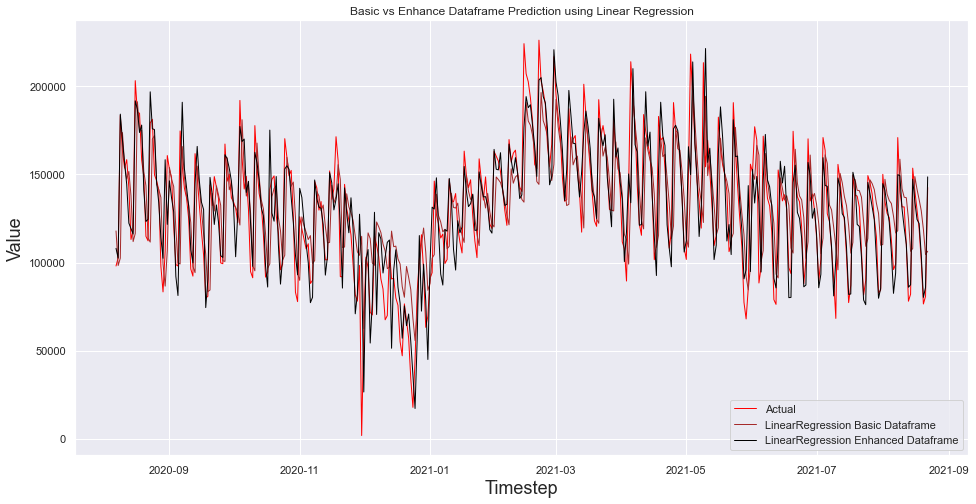

In [17]:
plt.figure(figsize =(16,8))
plt.title("Basic vs Enhance Dataframe Prediction using Linear Regression")
plt.xlabel("Timestep", fontsize =18)
plt.ylabel("Value", fontsize = 18)
plt.plot(basic_df[-(len(elastic_act)):]['date'],lm_basic_act,linewidth=1, color='red')
plt.plot(basic_df[-(len(elastic_act)):]['date'],lm_basic_pred, linewidth=1, color = 'brown')
plt.plot(basic_df[-(len(elastic_act)):]['date'],lm_pred, linewidth=1, color = 'black')
plt.legend(['Actual', 'LinearRegression Basic Dataframe', 'LinearRegression Enhanced Dataframe'], loc='lower right')
plt.show()

Plotting the error term between the Basic and Enhanced Dataframe, shows that the enhanced dataframe error terms oscillates closer to the 0 mean, showing that the enhanced feature space helped Linear Regression in better predicting the output.

In [18]:
def error_fn(actual, predicted):
    error =[]
    zip_object = zip(actual, predicted)
    for list1_i, list2_i in zip_object:
        error.append(list1_i-list2_i)
    return error

In [19]:
lm_basic_error = error_fn(lm_basic_act, lm_basic_pred)
lm_error = error_fn(lm_act, lm_pred)


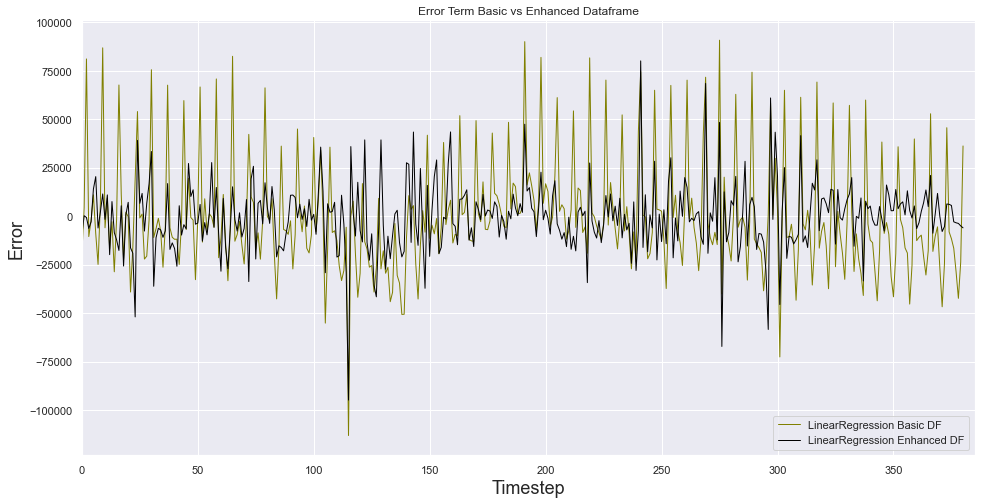

In [20]:
plt.figure(figsize =(16,8))
plt.title("Error Term Basic vs Enhanced Dataframe")
plt.xlabel("Timestep", fontsize =18)
plt.ylabel("Error", fontsize = 18)
plt.xlim([0,385])
#plt.axhline(y=0, color= 'red')
plt.plot(lm_basic_error, linewidth=1, color = 'olive')
plt.plot(lm_error, linewidth=1, color = 'black')
plt.legend(['LinearRegression Basic DF', 'LinearRegression Enhanced DF' ], loc='lower right')
plt.show()

### Models Evaluation

Plotting all the prediction models' results against the actual output, one can not that all closely track the actual output. Some minor outliers are noted, particularly for the Stochastic Gradient Descent model.

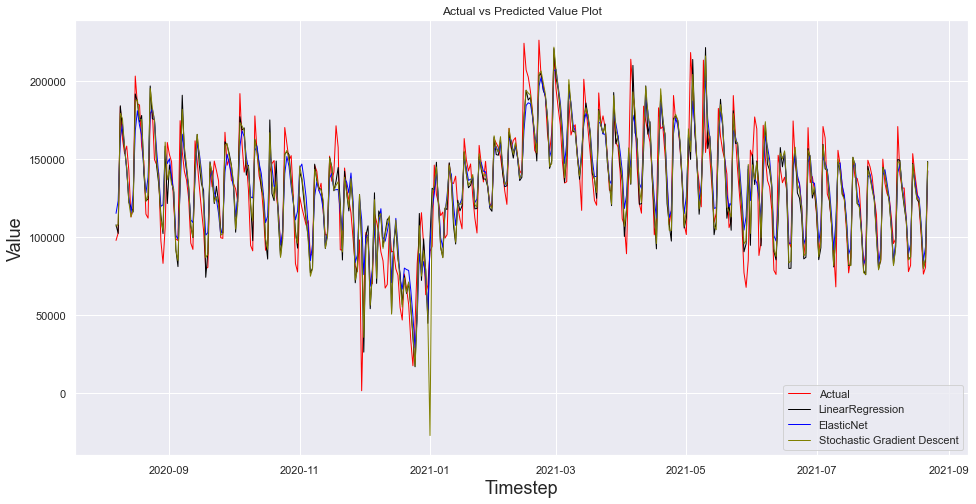

In [21]:
plt.figure(figsize =(16,8))
plt.title("Actual vs Predicted Value Plot")
plt.xlabel("Timestep", fontsize =18)
plt.ylabel("Value", fontsize = 18)
plt.plot(basic_df[-(len(elastic_act)):]['date'],elastic_act,linewidth=1, color='red')
plt.plot(basic_df[-(len(elastic_act)):]['date'],lm_pred, linewidth=1, color = 'black')
plt.plot(basic_df[-(len(elastic_act)):]['date'],elastic_pred, linewidth=1, color = 'blue')
plt.plot(basic_df[-(len(elastic_act)):]['date'],sgd_pred, linewidth=1, color = 'olive')
plt.legend(['Actual', 'LinearRegression', 'ElasticNet', 'Stochastic Gradient Descent'], loc='lower right')
plt.show()

The accuracy of each model can be better evaluated by plotting the error terms from the true output. It can be noted that certain fluctuations from the true output is experienced by all the models, suggesting that all models struggled to accurately predict some events. In other instances, the models produced an error close to 0, suggesting that managed to accurately track the output variable.  

In [22]:
lm_error = error_fn(lm_act, lm_pred)
elastic_error = error_fn(elastic_act, elastic_pred)
sgd_error = error_fn(sgd_act, sgd_pred)

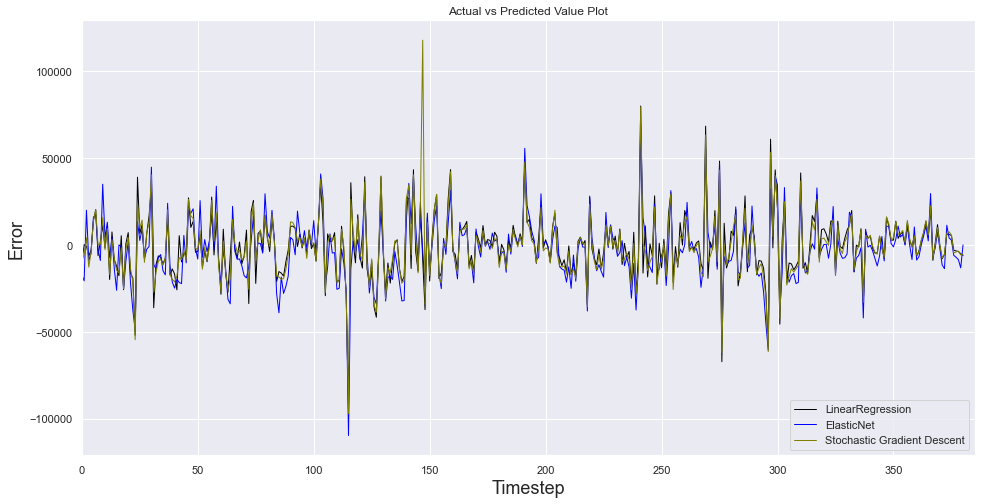

In [23]:
plt.figure(figsize =(16,8))
plt.title("Actual vs Predicted Value Plot")
plt.xlabel("Timestep", fontsize =18)
plt.ylabel("Error", fontsize = 18)
plt.xlim([0,385])
#plt.axhline(y=0, color= 'red')
plt.plot(lm_error, linewidth=1, color = 'black')
plt.plot(elastic_error, linewidth=1, color = 'blue')
plt.plot(sgd_error, linewidth=1, color = 'olive')
plt.legend(['LinearRegression', 'ElasticNet', 'Stochastic Gradient Descent' ], loc='lower right')
plt.show()